In [1]:
import sys
print (sys.executable)

/usr/local/opt/python@3.8/bin/python3.8


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import warnings
import yaml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import evolution
warnings.filterwarnings('ignore')

cm_lajolla = np.loadtxt("ColorMaps/lajolla/lajolla.txt")
lajolla = LinearSegmentedColormap.from_list("lajolla", cm_lajolla)
cm_oslo = np.loadtxt("ColorMaps/oslo/oslo.txt")
oslo = LinearSegmentedColormap.from_list("oslo", cm_oslo)
cm_bamako = np.loadtxt("ColorMaps/bamako/bamako.txt")
bamako = LinearSegmentedColormap.from_list("bamako", cm_bamako)
cm_nuuk = np.loadtxt("ColorMaps/nuuk/nuuk.txt")
nuuk = LinearSegmentedColormap.from_list("nuuk", cm_nuuk)
cm_vik = np.loadtxt("ColorMaps/vik/vik.txt")
vik = LinearSegmentedColormap.from_list("vik", cm_vik)
plots_folder = "./Figures/"

In [3]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

lajolla_r = reverse_colourmap(lajolla)
oslo_r = reverse_colourmap(oslo)
bamako_r = reverse_colourmap(bamako)

## Look at one case with a given planetary mass, bulk and mantle iron content, and light element fraction

In [4]:
Mp  = 1.9
XFe = 70.
FeM = 0.
S = 0.05

Planet = evolution.Rocky_Planet(Mp, XFe, FeM, S)

5000004000.0 0
The magnetic field lifetime is 5.0000000 billion years.


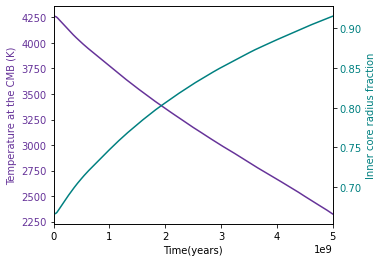

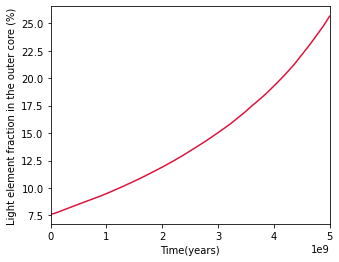

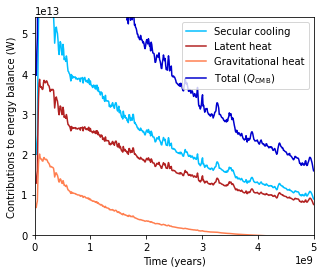

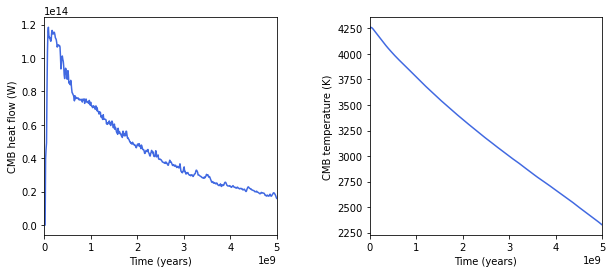

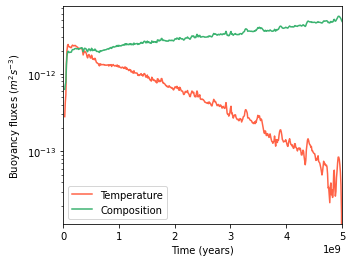

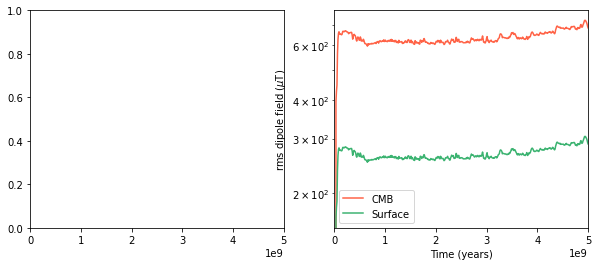

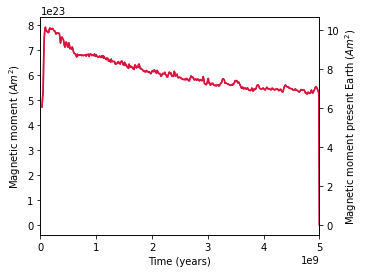

In [5]:
evo = evolution.Evolution(Planet)
evo.run()
evo.plot(plots_folder)

In [6]:
# print (evo.T_CMB[-1]) # Less light elements --> colder TCMB temperature, smaller adiabatic heat flow!
# print ((evo.r_IC[-1]/evo.planet.r_OC))
# print ((evo.r_IC[-1]/evo.planet.r_OC)**3)
print (evo.M)

[0.00000000e+00 4.73157296e+23 5.11738155e+23 5.35329261e+23
 6.75948020e+23 7.51648518e+23 7.85369226e+23 7.92958903e+23
 7.80283131e+23 7.76205904e+23 7.77269658e+23 7.73869321e+23
 7.71401426e+23 7.72712360e+23 7.85528667e+23 7.89815261e+23
 7.86595231e+23 7.84379872e+23 7.85402962e+23 7.88202189e+23
 7.87658224e+23 7.84626648e+23 7.79836736e+23 7.78792276e+23
 7.76927615e+23 7.72053289e+23 7.65520759e+23 7.68609964e+23
 7.69906120e+23 7.68552374e+23 7.69626470e+23 7.69596455e+23
 7.67436427e+23 7.51872808e+23 7.28978775e+23 7.40201377e+23
 7.51867704e+23 7.53374752e+23 7.47735307e+23 7.44726581e+23
 7.34953745e+23 7.19545649e+23 7.13092490e+23 7.26554095e+23
 7.33487014e+23 7.31380594e+23 7.21051381e+23 7.13611560e+23
 7.14023843e+23 7.30495731e+23 7.23125695e+23 7.07018637e+23
 7.09284506e+23 7.07875341e+23 7.04733885e+23 7.13860013e+23
 7.08296305e+23 6.97457458e+23 6.89463840e+23 6.88700402e+23
 6.86078171e+23 6.84850002e+23 6.79947536e+23 6.73510486e+23
 6.85012093e+23 6.787112

In [2]:
# If inner core, dT_dt should be smaller as we also have latent heat --> Lena is using a larger one, meaning that her interior is losing more heat
# than what it should be --> her Q_CMB should be lower.

# REVISION: Our T is larger than what Lena has --> this means we should be using a larger Q_CMB (Lena is using a smaller one)
# What happens if we add Q_ICB? T should be even larger!!

## QCMB evolution

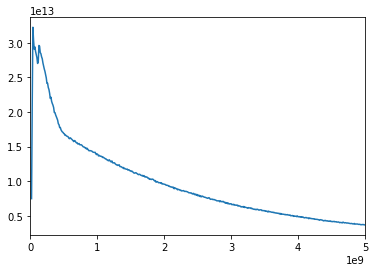

In [6]:
qcmb_ev = pd.read_csv("./Q_CMB/res_t_HS_Tm_Tb_qs_qc_M{:02d}_Fe{:02d}_#FeM{:02d}.res".format(int(10*Mp),int(XFe), int(FeM)), skipinitialspace=True, sep=" ", index_col=False,skiprows=[0])
qcmb_ev.columns = ["time", "H_rad", "T_um","T_cmb","q_surf","qcmb"]
time_vector = qcmb_ev["time"] *1e6
qcmb = qcmb_ev["qcmb"]

plt.plot(time_vector,qcmb*evo.planet.r_OC**2 * 4 * np.pi)
plt.xlim([0,5e9])
plt.show()

## Run cases for all Mp, all XFe, and a set amount of FeM (LE=0)

In [24]:
Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,1.7,1.8,1.9, 2.]
Fe = [15,20,25,30,35,40,45,50,55,60,65,70,75,80]
Fe_mantle = [0.00,10.,20.]
S = 0.0

M, F = np.meshgrid(Masses, Fe)
r_IC_end = np.zeros((len(Fe),len(Masses)*len(Fe_mantle)))
r_IC_beginning = np.zeros_like(r_IC_end)
MF_lifetime = np.zeros_like(r_IC_end)
MF_strength = np.zeros_like(r_IC_end)
MF_surface = np.zeros_like(r_IC_end)
tIC_80 = np.zeros_like(r_IC_end)
r_OC = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()
            
            r_IC_beginning[j,i+m*len(Masses)] = evo.planet.r_IC_0/1e3 
            r_IC_end[j,i+m*len(Masses)] = evo.r_IC[-1]/1e3      
            r_OC[j,i+m*len(Masses)] = evo.planet.r_OC/1e3
            MF_lifetime[j,i+m*len(Masses)] = evo.t_mf
            tIC_80[j,i+m*len(Masses)] = evo.t_80/1e9
            MF_strength[j,i+m*len(Masses)] = np.max(evo.M_ratio)
            MF_surface[j,i+m*len(Masses)] = np.max(evo.Bs*1e6)

0.8 15 0.0 0.0
The magnetic field lifetime is 1.74 billion years.
0.8 20 0.0 0.0
The magnetic field lifetime is 1.94 billion years.
0.8 25 0.0 0.0
The magnetic field lifetime is 2.24 billion years.
0.8 30 0.0 0.0
The magnetic field lifetime is 2.27 billion years.
0.8 35 0.0 0.0
The magnetic field lifetime is 2.34 billion years.
0.8 40 0.0 0.0
The magnetic field lifetime is 2.41 billion years.
0.8 45 0.0 0.0
The magnetic field lifetime is 2.48 billion years.
0.8 50 0.0 0.0
The magnetic field lifetime is 2.63 billion years.
0.8 55 0.0 0.0
The magnetic field lifetime is 2.69 billion years.
0.8 60 0.0 0.0
The magnetic field lifetime is 2.82 billion years.
0.8 65 0.0 0.0
0.040016750000000004
The magnetic field lifetime is 2.58 billion years.
0.8 70 0.0 0.0
0.04001106
The magnetic field lifetime is 2.22 billion years.
0.8 75 0.0 0.0
0.04000018
The magnetic field lifetime is 1.86 billion years.
0.8 80 0.0 0.0
0.04000651
The magnetic field lifetime is 0.85 billion years.
0.9 15 0.0 0.0
The mag

The magnetic field lifetime is 3.90 billion years.
1.6 65 0.0 0.0
The magnetic field lifetime is 3.14 billion years.
1.6 70 0.0 0.0
The magnetic field lifetime is 1.89 billion years.
1.6 75 0.0 0.0
The magnetic field lifetime is 1.54 billion years.
1.6 80 0.0 0.0
The magnetic field lifetime is 1.29 billion years.
1.7 15 0.0 0.0
The magnetic field lifetime is 2.84 billion years.
1.7 20 0.0 0.0
The magnetic field lifetime is 2.86 billion years.
1.7 25 0.0 0.0
The magnetic field lifetime is 2.99 billion years.
1.7 30 0.0 0.0
The magnetic field lifetime is 3.01 billion years.
1.7 35 0.0 0.0
The magnetic field lifetime is 3.06 billion years.
1.7 40 0.0 0.0
The magnetic field lifetime is 3.37 billion years.
1.7 45 0.0 0.0
The magnetic field lifetime is 3.36 billion years.
1.7 50 0.0 0.0
The magnetic field lifetime is 3.72 billion years.
1.7 55 0.0 0.0
The magnetic field lifetime is 3.90 billion years.
1.7 60 0.0 0.0
The magnetic field lifetime is 4.14 billion years.
1.7 65 0.0 0.0
The magnet

The magnetic field lifetime is 2.48 billion years.
1.2 35 10.0 0.0
The magnetic field lifetime is 2.79 billion years.
1.2 40 10.0 0.0
The magnetic field lifetime is 2.65 billion years.
1.2 45 10.0 0.0
The magnetic field lifetime is 2.19 billion years.
1.2 50 10.0 0.0
The magnetic field lifetime is 1.79 billion years.
1.2 55 10.0 0.0
The magnetic field lifetime is 1.49 billion years.
1.2 60 10.0 0.0
The magnetic field lifetime is 0.90 billion years.
1.2 65 10.0 0.0
The magnetic field lifetime is 0.82 billion years.
1.2 70 10.0 0.0
The magnetic field lifetime is 0.75 billion years.
1.2 75 10.0 0.0
0.04000878
The magnetic field lifetime is 0.66 billion years.
1.2 80 10.0 0.0
0.04001023
The magnetic field lifetime is 0.63 billion years.
1.3 15 10.0 0.0
The magnetic field lifetime is 2.52 billion years.
1.3 20 10.0 0.0
The magnetic field lifetime is 2.52 billion years.
1.3 25 10.0 0.0
The magnetic field lifetime is 2.48 billion years.
1.3 30 10.0 0.0
The magnetic field lifetime is 2.78 bill

The magnetic field lifetime is 0.66 billion years.
2.0 80 10.0 0.0
The magnetic field lifetime is 0.46 billion years.
0.8 15 20.0 0.0
The magnetic field lifetime is 0.60 billion years.
0.8 20 20.0 0.0
The magnetic field lifetime is 0.30 billion years.
0.8 25 20.0 0.0
The magnetic field lifetime is 0.26 billion years.
0.8 30 20.0 0.0
The magnetic field lifetime is 0.23 billion years.
0.8 35 20.0 0.0
The magnetic field lifetime is 0.72 billion years.
0.8 40 20.0 0.0
The magnetic field lifetime is 0.46 billion years.
0.8 45 20.0 0.0
The magnetic field lifetime is 0.32 billion years.
0.8 50 20.0 0.0
The magnetic field lifetime is 0.30 billion years.
0.8 55 20.0 0.0
The magnetic field lifetime is 0.29 billion years.
0.8 60 20.0 0.0
0.04004809
The magnetic field lifetime is 0.23 billion years.
0.8 65 20.0 0.0
0.050007680000000006
The magnetic field lifetime is 0.22 billion years.
0.8 70 20.0 0.0
0.06002051
The magnetic field lifetime is 0.19 billion years.
0.8 75 20.0 0.0
0.06000445
The magn

The magnetic field lifetime is 0.47 billion years.
1.6 40 20.0 0.0
The magnetic field lifetime is 0.41 billion years.
1.6 45 20.0 0.0
The magnetic field lifetime is 0.38 billion years.
1.6 50 20.0 0.0
The magnetic field lifetime is 0.35 billion years.
1.6 55 20.0 0.0
The magnetic field lifetime is 0.34 billion years.
1.6 60 20.0 0.0
The magnetic field lifetime is 0.32 billion years.
1.6 65 20.0 0.0
The magnetic field lifetime is 0.31 billion years.
1.6 70 20.0 0.0
The magnetic field lifetime is 0.25 billion years.
1.6 75 20.0 0.0
The magnetic field lifetime is 0.15 billion years.
1.6 80 20.0 0.0
0.040014020000000004
The magnetic field lifetime is 0.13 billion years.
1.7 15 20.0 0.0
The magnetic field lifetime is 1.10 billion years.
1.7 20 20.0 0.0
The magnetic field lifetime is 1.10 billion years.
1.7 25 20.0 0.0
The magnetic field lifetime is 0.68 billion years.
1.7 30 20.0 0.0
The magnetic field lifetime is 0.52 billion years.
1.7 35 20.0 0.0
The magnetic field lifetime is 0.43 billi

## Plotting functions

In [29]:
print (np.max(MF_lifetime))

4.150004


In [27]:
levels_rIC = np.linspace(0, 5500, 12)
levels_ICMF = np.linspace(0, 1, 11)
levels_MF = np.linspace(0, 5, 11)
levels_rIC08 = np.linspace(0,5,6)
levels_MFstr = np.linspace(0,9,10)
levels_MFsurf = np.linspace(0,700,8)
size = 13

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)

def plot_contourf(X,Y,arr,Masses,Fe,Fe_mantle,levels,plots_folder,colormap=plt.cm.magma,clabel="ICB radius (km)",figname="r_IC_FeM.pdf"):
    fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
    plt.subplots_adjust(wspace = 0.2)
    
    for i in range(len(Fe_mantle)):
        sc = ax[i].contourf(X,Y,arr[:,i*len(Masses):len(Masses)*(i+1)],levels, cmap = colormap) 
        sc2 = ax[i].contour(X,Y,arr[:,i*len(Masses):len(Masses)*(i+1)],levels,colors=('white',),linestyles=('-',),linewidths=(1,))
        ax[i].clabel(sc2, fmt = '%2d', colors = 'white', fontsize=11)
        #for a in range(len(Masses)):
            #for b in range(len(Fe)):
                #ax[i].scatter(Masses[a],Fe[b],s=size,color='white',edgecolors='k')
        if i!=0:
            ax[i].set_ylabel("")
        else:
            ax[i].set_ylabel("Fe content (wt.%)")
        ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]*1e-2))
        ax[i].yaxis.set_ticks_position('both')
        ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
        ax[i].set_xlim([0.8,2.0])
        ax[i].set_ylim([15,80])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
    cb = fig.colorbar(sc, cax=cbar_ax)
    cb.set_label(clabel)
    plt.savefig(plots_folder + figname, bbox_inches="tight")
    plt.show()
    
def plot_contourfM(X,Y,arr,Masses,Fe,yl,levels,plots_folder,Ylabel = "#$Fe_{M}$",clabel="ICB radius (km)",figname="r_IC_FeM.pdf"):
    fig, ax = plt.subplots(1, len(Masses), figsize=[16,3],sharey=True,sharex=True)
    plt.subplots_adjust(wspace = 0.2)

    levels_rIC = np.linspace(0, 5500, 12)
    for i in range(len(Masses)):
        sc = ax[i].contourf(X,Y,arr[:,i*len(Fe):len(Fe)*(i+1)],levels, cmap = plt.cm.magma)  
        for a in range(len(Fe)):
            for b in range(len(yl)):
                ax[i].scatter(Fe[a],yl[b],s=size,color='white',edgecolors='k')
        if i!=0:
            ax[i].set_ylabel("")
        else:
            ax[i].set_ylabel(Ylabel)
        ax[i].set_title("{:.1f}".format(Masses_[i]) + r" $M_{Earth}$")
        ax[i].yaxis.set_ticks_position('both')
        ax[i].set_xlabel("Fe content (wt.%)")
        ax[i].yaxis.set_ticks_position('both')
        ax[i].set_xlim([15,75])
        if Ylabel == "LE":
            ax[i].set_ylim([0,0.1])
        else:
            ax[i].set_ylim([0,20])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
    cb = fig.colorbar(sc, cax=cbar_ax)
    cb.set_label(clabel)
    plt.savefig(plots_folder + figname, bbox_inches="tight")
    plt.show()

colors = ["coral","crimson","darkmagenta"]
#ls = ["-",":"]
ls = ["-","-"]
label_mass = ["1 $M_{Earth}$","1.5 $M_{Earth}$","2 $M_{Earth}$"]

def plot_evolution(nplot,Masses,Fe,arr,yl,figsize=[10,4],leg=(0.98, 0.98),yltop=[3,3],ylbot=[3,3],figname = "Evo_TICB_rICBFUNC.pdf"):
    fig, ax = plt.subplots(1, nplot,figsize=figsize,sharex=True)
    for b in range(nplot):
        for i, mass in enumerate(Masses):
            for j,iron in enumerate(Fe):
                if nplot ==1:
                    ax.plot(time[:,i+j*len(Masses)]/1e9,arr[:,i+j*len(Masses)],color=colors[j],linestyle=ls[j])
                    ax.set_ylabel(yl)
                    ax.set_xlabel('Time (Gyr)')
                    ax.set_xlim([0,5])
                    if j==0:
                        ax.plot(time[:,i+j*len(Masses)]/1e9,arr[:,i+j*len(Masses)],color=colors[j],linestyle=ls[j],label=label_mass[i])                   
                else:    
                    arr_plot = arr[b]
                    ax[b].plot(time[:,i+j*len(Masses)]/1e9,arr_plot[:,i+j*len(Masses)],color=colors[j],linestyle=ls[j])
                    ax[b].set_ylabel(yl[b])
                    ax[b].set_xlabel('Time (Gyr)')
                    ax[b].set_xlim([0,5])
                    ax[b].set_ylim(bottom=ylbot[b],top=yltop[b])
                    if j==0 and b==nplot-1:
                        arr_plot = arr[b]
                        ax[b].plot(time[:,i+j*len(Masses)]/1e9,arr_plot[:,i+j*len(Masses)],color=colors[j],linestyle=ls[j],label=label_mass[i])
                if yl == ["ICB temperature (K)","Inner core radius (km)"]:# and arr[1][0]==0.:
                    ax[1].scatter(t_IC0[i]/1e9,0,s=30,color='lightseagreen',marker='*')
                    ax[0].scatter(t_IC0[i]/1e9,T_IC0[i],s=30,color='lightseagreen',marker='*')
                if yl == ["CMB heat flow (TW)","CMB temperature (K)"] and Fe==[0,10]:
                    ax[1].scatter(t_IC0[i]/1e9,T_CMB0[i],s=30,color='lightseagreen',marker='*')
    display = (0,1,2,3,4)
    XFe_noic = plt.Line2D((0,1),(0,0), color='k')
    XFe_ic = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')
    if nplot>1:
        ax1 = ax[nplot-1]
        plt.subplots_adjust(wspace = 0.3)
    else:
        ax1 = plt.gca()
    #handles, labels = ax1.get_legend_handles_labels()
    #ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[XFe_noic,XFe_ic],
    #    [label for i,label in enumerate(labels) if i in display]+['$X_{Fe}$=25','$X_{Fe}$=55'],bbox_to_anchor=leg,borderaxespad=0.,fontsize=8) 
    if yl=="Magnetic moment ($A m^{2}$)":
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Magnetic moment present Earth ($A m^{2}$)')  
        ax2.set_ylim([0,3])
    plt.savefig(plots_folder + figname, bbox_inches="tight")
    plt.show() 

## Plots

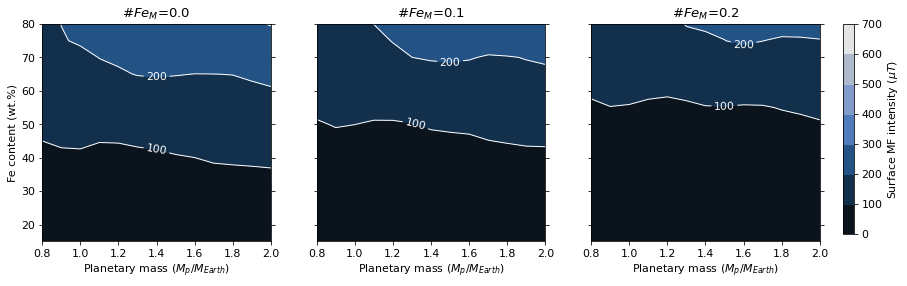

In [28]:
#plot_contourf(M,F,r_IC_beginning/r_OC,Masses,Fe,Fe_mantle,levels_ICMF,plots_folder,colormap=plt.cm.magma,clabel="$r_{IC_{0}}$/$r_{OC}$",figname="ICMF0_FeM.pdf")

#plot_contourf(M,F,r_IC_end/r_OC,Masses,Fe,Fe_mantle,levels_ICMF,plots_folder,colormap=plt.cm.magma,clabel="$r_{IC}$/$r_{OC}$",figname="ICMF_FeM.pdf")

# MF lifetime
#plot_contourf(M,F,MF_lifetime,Masses,Fe,Fe_mantle,levels_MF,plots_folder,colormap=oslo,clabel="Magnetic field lifetime (Gyr)",figname="MF_lifetime_FeM.pdf")

# Dipole moment
#plot_contourf(M,F,MF_strength,Masses,Fe,Fe_mantle,levels_MFstr,plots_folder,colormap=oslo,clabel="Magnetic moment ($M_{m_{Earth}}$)",figname="MM.pdf")

# Surface strength
plot_contourf(M,F,MF_surface,Masses,Fe,Fe_mantle,levels_MFsurf,plots_folder,colormap=oslo,clabel="Surface MF intensity ($\mu T$)",figname="M_surf.pdf")

## Plot the two observables (planetary mass and radius) with corresponding MF lifetime

In [14]:
Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,1.7,1.8,1.9, 2.]
Fe = [15,20,25,30,35,40,45,50,55,60,65,70,75,80]
Fe_mantle = [0.00]
S = 0.0

M, F = np.meshgrid(Masses, Fe)
r_IC_end = np.zeros((len(Fe),len(Masses)*len(Fe_mantle)))
MF_lifetime = np.zeros_like(r_IC_end)
r_OC = np.zeros_like(r_IC_end)
r_planet = np.zeros_like(r_IC_end)
MP = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()
            
            r_OC[j,i+m*len(Masses)] = evo.planet.r_OC
            MF_lifetime[j,i+m*len(Masses)] = evo.t_mf
            r_planet[j,i+m*len(Masses)] = evo.planet.r_planet
            MP[j,i+m*len(Masses)] = evo.planet.Mp


0.8 15 0.0 0.0
1740001000.0 0
The magnetic field lifetime is 1.7400010 billion years.
0.8 20 0.0 0.0
1940007000.0 0
The magnetic field lifetime is 1.9400070 billion years.
0.8 25 0.0 0.0
2240001000.0 0
The magnetic field lifetime is 2.2400010 billion years.
0.8 30 0.0 0.0
2270014000.0 0
The magnetic field lifetime is 2.2700140 billion years.
0.8 35 0.0 0.0
2340002000.0 0
The magnetic field lifetime is 2.3400020 billion years.
0.8 40 0.0 0.0
2410005000.0 0
The magnetic field lifetime is 2.4100050 billion years.
0.8 45 0.0 0.0
2480002000.0 0
The magnetic field lifetime is 2.4800020 billion years.
0.8 50 0.0 0.0
2630018000.0 0
The magnetic field lifetime is 2.6300180 billion years.
0.8 55 0.0 0.0
2690013000.0 0
The magnetic field lifetime is 2.6900130 billion years.
0.8 60 0.0 0.0
2820017000.0000005 0
The magnetic field lifetime is 2.8200170 billion years.
0.8 65 0.0 0.0
0.040016750000000004
2620019000.0 40016750.0
The magnetic field lifetime is 2.5800023 billion years.
0.8 70 0.0 0.0
0.0

2950007000.0 0
The magnetic field lifetime is 2.9500070 billion years.
1.4 50 0.0 0.0
3080005000.0 0
The magnetic field lifetime is 3.0800050 billion years.
1.4 55 0.0 0.0
3220000000.0 0
The magnetic field lifetime is 3.2200000 billion years.
1.4 60 0.0 0.0
3520005000.0 0
The magnetic field lifetime is 3.5200050 billion years.
1.4 65 0.0 0.0
2430004000.0 0
The magnetic field lifetime is 2.4300040 billion years.
1.4 70 0.0 0.0
1910000000.0 0
The magnetic field lifetime is 1.9100000 billion years.
1.4 75 0.0 0.0
1590004000.0 0
The magnetic field lifetime is 1.5900040 billion years.
1.4 80 0.0 0.0
1360000000.0 0
The magnetic field lifetime is 1.3600000 billion years.
1.5 15 0.0 0.0
2820010000.0 0
The magnetic field lifetime is 2.8200100 billion years.
1.5 20 0.0 0.0
2800017000.0000005 0
The magnetic field lifetime is 2.8000170 billion years.
1.5 25 0.0 0.0
2840008000.0 0
The magnetic field lifetime is 2.8400080 billion years.
1.5 30 0.0 0.0
2890002999.9999995 0
The magnetic field lifetime

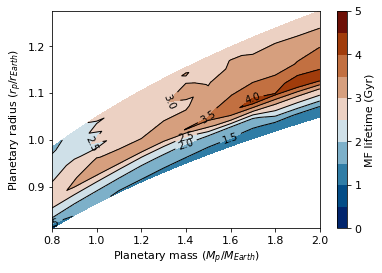

In [34]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

levels_obs = np.linspace(0,5,11)
#levels_obs = np.linspace(1,5,9)
sc = plt.contourf(MP,r_planet/6371e3,MF_lifetime,edgecolor='black',levels=levels_obs,cmap=vik)#'RdYlBu_r')
sc2 = plt.contour(MP,r_planet/6371e3,MF_lifetime,levels=levels_obs,colors=('black',),linestyles=('-',),linewidths=(1,))
plt.clabel(sc2, fmt = '%2.1f', colors = 'black', fontsize=10)
#plt.scatter(MP,r_planet/6371e3,MF_lifetime,edgecolor='black')
cb = plt.colorbar(sc)
cb.set_label('MF lifetime (Gyr)')
plt.xlabel('Planetary mass ($M_{p}/M_{Earth}$)')
plt.ylabel('Planetary radius ($r_{p}/r_{Earth}$)')
plt.savefig(plots_folder+'Obs.pdf')
plt.show()

## Plot time needed to reach 70% of the outer core size

In [14]:
Masses = [1.,2.]
Fe_mantle = [0.]
Fe = [15,20,25,30,35,40,45,50,55,60,65,70,75,80]
S = 0.0

M, F = np.meshgrid(Masses, Fe)
r_IC_end = np.zeros((len(Fe),len(Masses)*len(Fe_mantle)))
tIC_80_0 = np.zeros_like(r_IC_end)
r_OC = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()
            
            tIC_80_0[j,i+m*len(Masses)] = evo.t_80/1e9
            if evo.t_80/1e9<0.04:
                tIC_80_0[j,i+m*len(Masses)]=0.
            if evo.t_80==0.:
                tIC_80_0[j,i+m*len(Masses)]=6.
            print (tIC_80_0[j,i+m*len(Masses)])

Fe_mantle = [10.]
tIC_80_10 = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()
            
            tIC_80_10[j,i+m*len(Masses)] = evo.t_80/1e9
            if evo.t_80/1e9<0.04:
                tIC_80_10[j,i+m*len(Masses)] =0.
            if evo.t_80==0.:
                tIC_80_10[j,i+m*len(Masses)]=6.

Fe_mantle = [20.]
tIC_80_20 = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()
            
            tIC_80_20[j,i+m*len(Masses)] = evo.t_80/1e9
            if evo.t_80/1e9<0.04:
                tIC_80_20[j,i+m*len(Masses)] =0.

1.0 15 0.0 0.0
The magnetic field lifetime is 2.63 billion years.
6.0
1.0 20 0.0 0.0
The magnetic field lifetime is 2.46 billion years.
6.0
1.0 25 0.0 0.0
The magnetic field lifetime is 2.68 billion years.
6.0
1.0 30 0.0 0.0
The magnetic field lifetime is 2.39 billion years.
6.0
1.0 35 0.0 0.0
The magnetic field lifetime is 2.58 billion years.
4.700025
1.0 40 0.0 0.0
The magnetic field lifetime is 2.37 billion years.
3.6800040000000003
1.0 45 0.0 0.0
The magnetic field lifetime is 2.84 billion years.
1.540003
1.0 50 0.0 0.0
The magnetic field lifetime is 3.04 billion years.
0.910007
1.0 55 0.0 0.0
The magnetic field lifetime is 3.25 billion years.
0.4200061
1.0 60 0.0 0.0
The magnetic field lifetime is 3.20 billion years.
0.060023219999999995
1.0 65 0.0 0.0
The magnetic field lifetime is 2.62 billion years.
0.0
1.0 70 0.0 0.0
The magnetic field lifetime is 2.17 billion years.
0.0
1.0 75 0.0 0.0
0.040007650000000006
The magnetic field lifetime is 1.80 billion years.
0.0
1.0 80 0.0 0.0
0

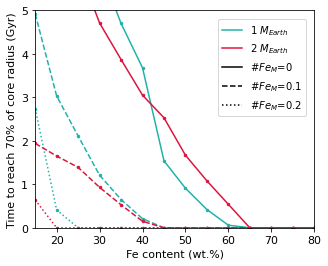

In [15]:
labels = ["1 $M_{Earth}$","2 $M_{Earth}$"]
colors = ["lightseagreen","crimson"]
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)
plt.figure(figsize=[5,4])
for i in range(len(Masses)):
    plt.plot(F[:,i],tIC_80_0[:,i],label=labels[i],color=colors[i],linestyle='-')
    plt.scatter(F[:,i],tIC_80_0[:,i],color=colors[i],s=6)
    plt.plot(F[:,i],tIC_80_10[:,i],color=colors[i],linestyle='--')
    plt.scatter(F[:,i],tIC_80_10[:,i],color=colors[i],s=6)
    plt.plot(F[:,i],tIC_80_20[:,i],color=colors[i],linestyle=':')
    plt.scatter(F[:,i],tIC_80_20[:,i],color=colors[i],s=6)
plt.legend()
plt.xlabel('Fe content (wt.%)')
plt.ylabel('Time to reach 70% of core radius (Gyr)')
plt.xlim([15,80])
plt.ylim([0.,5.])
ax = plt.gca()
display = (0,1,2,3,4)
FeM_0 = plt.Line2D((0,1),(0,0), color='k')
FeM_10 = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle='--')
FeM_20 = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handle for i,handle in enumerate(handles) if i in display]+[FeM_0,FeM_10,FeM_20],
[label for i,label in enumerate(labels) if i in display]+['#$Fe_{M}$=0','#$Fe_{M}$=0.1', '#$Fe_{M}$=0.2' ],bbox_to_anchor=(0.97,0.96),borderaxespad=0.,fontsize=10)
plt.savefig(plots_folder+"70%core.pdf")
plt.show()

## Evolutions for planets of different mass and FeM (FeM=0 and FeM=10)

In [8]:
# colors = ["coral","crimson","darkmagenta"]
colors = ["lightseagreen","crimson"]
ls = ["-",":"]
label_mass = ["1 $M_{Earth}$","2 $M_{Earth}$"]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)

def plot_evolution(nplot,Masses,Fe,arr,yl,leg,figsize=[10,4],figname = "example.pdf"):
    fig, ax = plt.subplots(1, nplot,figsize=figsize,sharex=True)
    for b in range(nplot):
        for i, mass in enumerate(Masses):
            for j,iron in enumerate(Fe):
                if nplot ==1:
                    ax.plot(time[1:,i+j*len(Masses)]/1e9,arr[1:,i+j*len(Masses)],color=colors[i],linestyle=ls[j])
                    ax.set_ylabel(yl)
                    ax.set_xlabel('Time (Gyr)')
                    ax.set_xlim([0,5])
                    if j==0:
                        ax.plot(time[1:,i+j*len(Masses)]/1e9,arr[1:,i+j*len(Masses)],color=colors[i],linestyle=ls[j],label=label_mass[i])                   
                else:    
                    arr_plot = arr[b]
                    ax[b].plot(time[1:,i+j*len(Masses)]/1e9,arr_plot[1:,i+j*len(Masses)],color=colors[i],linestyle=ls[j])
                    ax[b].set_ylabel(yl[b])
                    ax[b].set_xlabel('Time (Gyr)')
                    ax[b].set_xlim([0,5])
                    if j==0 and b==nplot-1:
                        arr_plot = arr[b]
                        ax[b].plot(time[1:,i+j*len(Masses)]/1e9,arr_plot[1:,i+j*len(Masses)],color=colors[i],linestyle=ls[j],label=label_mass[i])
                if yl == ["Inner core radius fraction (%)","CMB temperature (K)"]:
                    ax[0].scatter(t_IC0[i]/1e9,0,s=30,color=colors[i],marker='*')
                    #ax[0].scatter(t_IC0[i]/1e9,T_IC0[i],s=30,color=colors[i],marker='*')
                    ax[1].scatter(t_IC0[i]/1e9,T_CMB0[i],s=30,color=colors[i],marker='*')
                if yl == ["CMB heat flow (W)","Secular cooling (W)","Latent + Gravitational heat (W)"]:
                    ax[b].set_ylim([0,1.5e14])
    display = (0,1,2,3,4)
    XFe_noic = plt.Line2D((0,1),(0,0), color='k')
    XFe_ic = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')
    if nplot>1:
        ax1 = ax[nplot-1]
        plt.subplots_adjust(wspace = 0.3)
    else:
        ax1 = plt.gca()
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend([handle for i,handle in enumerate(handles) if i in display]+[XFe_noic,XFe_ic],
        [label for i,label in enumerate(labels) if i in display]+['$X_{Fe}$=30 wt%','$X_{Fe}$=60 wt%'],bbox_to_anchor=leg,borderaxespad=0.,fontsize=10) 
    if yl=="Magnetic moment ($A m^{2}$)":
        ax2 = ax1.twinx() 
        ax2.set_ylabel('Magnetic moment present Earth ($A m^{2}$)')  
        ax2.set_ylim([0,3])
    plt.savefig(plots_folder + figname, bbox_inches="tight")
    plt.show() 

The magnetic field lifetime is 2.38 billion years.
The magnetic field lifetime is 2.95 billion years.
The magnetic field lifetime is 3.12 billion years.
The magnetic field lifetime is 3.72 billion years.


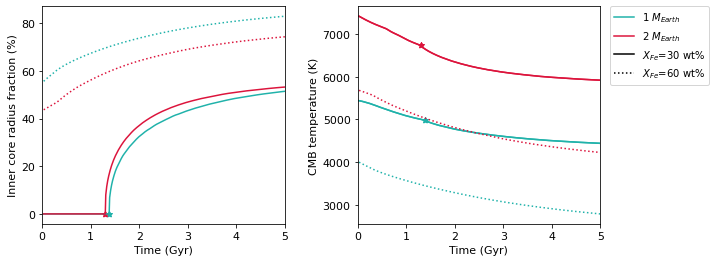

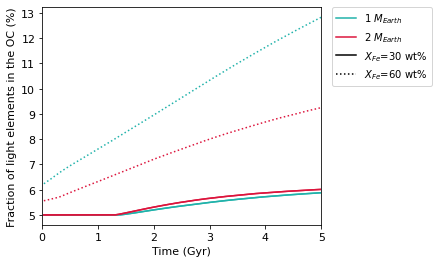

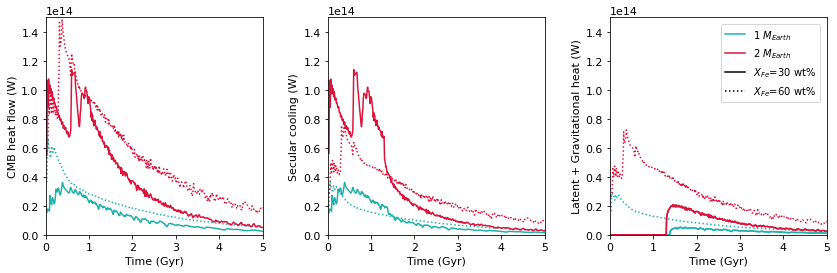

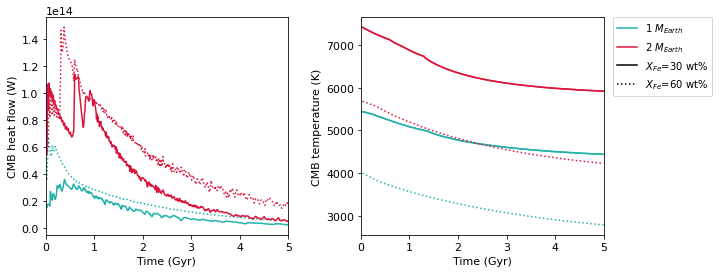

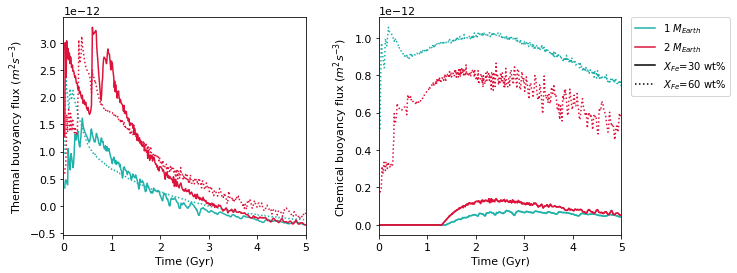

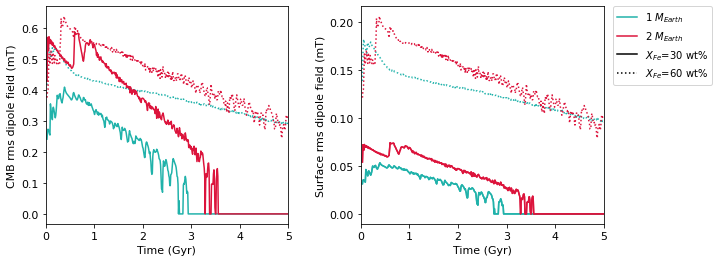

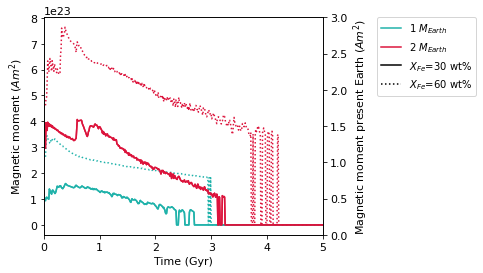

In [12]:
Masses = [1.,2.]
Fe = [30.,60.]
Fe_mantle = 0.
S=0.05

T_ICB = np.zeros((499,len(Fe)*len(Masses)),dtype=np.float64)
time = np.zeros_like(T_ICB)
r_ICB = np.zeros_like(T_ICB)
QC = np.zeros_like(T_ICB)
QL = np.zeros_like(T_ICB)
QX = np.zeros_like(T_ICB)
Q_comb = np.zeros_like(T_ICB)
Q_CMB = np.zeros_like(T_ICB)
T_CMB = np.zeros_like(T_ICB)
F_th = np.zeros_like(T_ICB)
F_X = np.zeros_like(T_ICB)
Bc = np.zeros_like(T_ICB)
Bs = np.zeros_like(T_ICB)
M = np.zeros_like(T_ICB)
M_ratio = np.zeros_like(T_ICB)
S_t = np.zeros_like(T_ICB)
t_IC0 = np.zeros((len(Fe)*len(Masses),1),dtype=np.float64)
T_IC0 = np.zeros_like(t_IC0)
T_CMB0 = np.zeros_like(t_IC0)

for i, mass in enumerate(Masses):
    for j,iron in enumerate(Fe):
        Mp = mass
        XFe = iron
        FeM = Fe_mantle
        
        Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
        evo = evolution.Evolution(Planet)
        evo.run()
            
        T_ICB[:,i+j*len(Masses)] = evo.T
        r_ICB[:,i+j*len(Masses)] = (evo.r_IC/evo.planet.r_OC)*100.
        QC[:,i+j*len(Masses)] = evo.QC
        QL[:,i+j*len(Masses)] = evo.QL
        QX[:,i+j*len(Masses)] = evo.QX
        Q_comb[:,i+j*len(Masses)] = QL[:,i+j*len(Masses)] + QX[:,i+j*len(Masses)]
        Q_CMB[:,i+j*len(Masses)] = evo.Q_CMB
        T_CMB[:,i+j*len(Masses)] = evo.T_CMB
        F_th[:,i+j*len(Masses)] = evo.F_th
        F_X[:,i+j*len(Masses)] = evo.F_X
        Bc[:,i+j*len(Masses)] = evo.Bc
        Bs[:,i+j*len(Masses)] = evo.Bs
        M[:,i+j*len(Masses)] = evo.M
        M_ratio[:,i+j*len(Masses)] = evo.M_ratio
        S_t[:,i+j*len(Masses)] = evo.S_t
        if r_ICB[0,i+j*len(Masses)] ==0:
            t_IC0[i] = evo.t_IC0
            T_IC0[i] = evo.T_IC0
            T_CMB0[i]=evo.T_CMB0
        time[:,i+j*len(Masses)] = evo.planet.time_vector

# Plot r_ICB and T_ICB
yl = ["Inner core radius fraction (%)","CMB temperature (K)",]
arr = [r_ICB,T_CMB]
plot_evolution(2,Masses,Fe,arr,yl,leg=(1.45,1.0),figsize=[10,4],figname = "Evo_TCMB_rICB.pdf")

# Plot evolution of light elements
if S!=0.:
    plot_evolution(1,Masses,Fe,S_t*1e2,yl="Fraction of light elements in the OC (%)",leg=(1.04, 1.),figsize=[5,4],figname = "Evo_SFUNC.pdf")

# Plot energy budgets
yl = ["CMB heat flow (W)","Secular cooling (W)","Latent + Gravitational heat (W)"]
arr = [Q_CMB,QC,Q_comb]
plot_evolution(3,Masses,Fe,arr,yl,leg=(0.97, 0.97),figsize=[14,4],figname = "Evo_Energies.pdf")

# T_CMB and Q_CMB
yl = ["CMB heat flow (W)","CMB temperature (K)"]
arr = [Q_CMB,T_CMB]
plot_evolution(2,Masses,Fe,arr,yl,leg=(1.04, 1.),figsize=[10,4],figname = "Evo_QCMB_TCMB.pdf")

# Plot buoyancy fluxes
yl = ["Thermal buoyancy flux ($m^{2}s^{-3}$)","Chemical buoyancy flux ($m^{2}s^{-3}$)"]
arr = [F_th,F_X]
plot_evolution(2,Masses,Fe,arr,yl,leg=(1.45, 1.),figsize=[10,4],figname = "Evo_buoyancy.pdf")

# Plot rms dipole field at the surface and at the CMB
yl = ["CMB rms dipole field (mT)","Surface rms dipole field (mT)"]
arr = [Bc*1e3,Bs*1e3]
plot_evolution(2,Masses,Fe,arr,yl,leg=(1.04, 1.),figsize=[10,4],figname = "Evo_rms.pdf")

# Plot magnetic moment evolution
plot_evolution(1,Masses,Fe,M,yl="Magnetic moment ($A m^{2}$)",leg=(1.55, 1.),figsize=[5,4],figname = "Evo_MF.pdf")

In [11]:
Masses = [1.]
Fe = [25.,50.]
Fe_mantle = 0.
S=0.

T_ICB = np.zeros((499,len(Fe)*len(Masses)),dtype=np.float64)
time = np.zeros_like(T_ICB)
r_ICB = np.zeros_like(T_ICB)
QC = np.zeros_like(T_ICB)
QL = np.zeros_like(T_ICB)
QX = np.zeros_like(T_ICB)
Q_CMB = np.zeros_like(T_ICB)
T_CMB = np.zeros_like(T_ICB)
F_th = np.zeros_like(T_ICB)
F_X = np.zeros_like(T_ICB)
Bc = np.zeros_like(T_ICB)
Bs = np.zeros_like(T_ICB)
M = np.zeros_like(T_ICB)
M_ratio = np.zeros_like(T_ICB)
S_t = np.zeros_like(T_ICB)
t_IC0 = np.zeros((len(Fe)*len(Masses),1),dtype=np.float64)
T_IC0 = np.zeros_like(t_IC0)
T_CMB0 = np.zeros_like(t_IC0)

for i, mass in enumerate(Masses):
    for j,iron in enumerate(Fe):
        Mp = mass
        FeM = Fe_mantle
        XFe = iron
        S=0.
        
        Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
        evo = evolution.Evolution(Planet)
        evo.run()
            
        T_ICB[:,i+j*len(Masses)] = evo.T
        r_ICB[:,i+j*len(Masses)] = evo.r_IC
        QC[:,i+j*len(Masses)] = evo.QC
        QL[:,i+j*len(Masses)] = evo.QL
        QX[:,i+j*len(Masses)] = evo.QX
        Q_CMB[:,i+j*len(Masses)] = evo.Q_CMB
        T_CMB[:,i+j*len(Masses)] = evo.T_CMB
        F_th[:,i+j*len(Masses)] = evo.F_th
        F_X[:,i+j*len(Masses)] = evo.F_X
        Bc[:,i+j*len(Masses)] = evo.Bc
        Bs[:,i+j*len(Masses)] = evo.Bs
        M[:,i+j*len(Masses)] = evo.M
        M_ratio[:,i+j*len(Masses)] = evo.M_ratio
        S_t[:,i+j*len(Masses)] = evo.S_t
        if r_ICB[0,i+j*len(Masses)] == 0:
            t_IC0[i] = evo.t_IC0
            T_IC0[i] = evo.T_IC0
            T_CMB0[i] = evo.T_CMB0
        time[:,i+j*len(Masses)] = evo.planet.time_vector

colors = ["lightseagreen","crimson"]
# Plot r_ICB and T_ICB
yl = ["ICB temperature (K)","Inner core radius (km)"]
arr = [T_ICB,r_ICB/1e3]
plot_evolution(2,Masses,Fe,arr,yl,figsize=[10,4],leg=(1.04, 1.),yltop=[10400,4600],ylbot=[3500,-100],figname = "Evo_rIC.pdf")

# Plot evolution of light elements
if S!=0.:
    plot_evolution(1,Masses,Fe,S_t*1e2,yl="Fraction of light elements (%)",figsize=[5,4],leg=(1.04, 1.),yltop=[100],ylbot=[0],figname = "Evo_LE.pdf")

# Plot energy budgets
yl = ["Secular cooling (TW)","Latent + Gravitational heat (TW)"]
arr = [QC/1e12,QL/1e12+QX/1e12]
plot_evolution(2,Masses,Fe,arr,yl,figsize=[10,4],yltop=[40,40],ylbot=[0,0],leg = (1.35, 1.),figname = "Evo_Energy.pdf")

# T_CMB and Q_CMB
yl = ["CMB heat flow (TW)","CMB temperature (K)"]
arr = [Q_CMB/1e12,T_CMB]
plot_evolution(2,Masses,Fe,arr,yl,figsize=[10,4],yltop=[40,8000],ylbot=[0,2000],leg = (1.32, 1.),figname = "Evo_CMB.pdf")

# Plot buoyancy fluxes
yl = ["Thermal buoyancy flux ($m^{2}s^{-3}$)","Compositional buoyancy flux ($m^{2}s^{-3}$)"]
arr = [F_th,F_X]
plot_evolution(2,Masses,Fe,arr,yl,figsize=[10,4],yltop=[3e-12,6.5e-13],ylbot=[0,0],leg = (1.32, 1.),figname = "Evo_Fluxes.pdf")

# Plot rms dipole field at the surface and at the CMB
yl = ["CMB rms dipole field (mT)","Surface rms dipole field (mT)"]
arr = [Bc*1e3,Bs*1e3]
plot_evolution(2,Masses,Fe,arr,yl,figsize=[10,4],yltop=[0.7,0.2],ylbot=[0,0],leg = (1.32, 1.),figname = "Evo_rms.pdf")

# Plot magnetic moment evolution
plot_evolution(1,Masses,Fe,M,yl="Magnetic moment ($A m^{2}$)",figsize=[5,4],yltop=[6.6e23],ylbot=[0],leg=(0.98, 0.98),figname = "Evo_MF.pdf")

The magnetic field lifetime is 2.68 billion years.
The magnetic field lifetime is 3.04 billion years.


TypeError: plot_evolution() got an unexpected keyword argument 'yltop'

## Compare T0 and Tmelt0 for planets with different amounts of light elements and FeM

In [12]:
Fe_mantle = [0.,5.,10.,15.,20.]
Masses = [0.8, 1.0, 1.5, 2.]
Fe = 45.
LE = [0.,0.05]

TL0 = np.zeros((len(Fe_mantle),len(Masses)*len(LE)),dtype=np.float64)
T0 = np.zeros((len(Fe_mantle),len(Masses)*len(LE)),dtype=np.float64)

for m, light_elements in enumerate(LE):
    for i, mass in enumerate(Masses):
        for j,iron_mantle in enumerate(Fe_mantle):
            Mp = mass
            XFe = Fe
            S = light_elements
            FeM = iron_mantle
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)

            evo.run()

            TL0[j,i+m*len(Masses)] = evo.planet.TL0 
            T0[j,i+m*len(Masses)] = evo.planet.T0

0.8 45.0 0.0 0.0
0.8 45.0 5.0 0.0
0.8 45.0 10.0 0.0
0.8 45.0 15.0 0.0
0.8 45.0 20.0 0.0
1.0 45.0 0.0 0.0
1.0 45.0 5.0 0.0
1.0 45.0 10.0 0.0
1.0 45.0 15.0 0.0
1.0 45.0 20.0 0.0
1.5 45.0 0.0 0.0
1.5 45.0 5.0 0.0
1.5 45.0 10.0 0.0
1.5 45.0 15.0 0.0
1.5 45.0 20.0 0.0
2.0 45.0 0.0 0.0
2.0 45.0 5.0 0.0
2.0 45.0 10.0 0.0
2.0 45.0 15.0 0.0
2.0 45.0 20.0 0.0
0.8 45.0 0.0 0.05
0.8 45.0 5.0 0.05
0.8 45.0 10.0 0.05
0.8 45.0 15.0 0.05
0.8 45.0 20.0 0.05
1.0 45.0 0.0 0.05
1.0 45.0 5.0 0.05
1.0 45.0 10.0 0.05
1.0 45.0 15.0 0.05
1.0 45.0 20.0 0.05
1.5 45.0 0.0 0.05
1.5 45.0 5.0 0.05
1.5 45.0 10.0 0.05
1.5 45.0 15.0 0.05
1.5 45.0 20.0 0.05
2.0 45.0 0.0 0.05
2.0 45.0 5.0 0.05
2.0 45.0 10.0 0.05
2.0 45.0 15.0 0.05
2.0 45.0 20.0 0.05


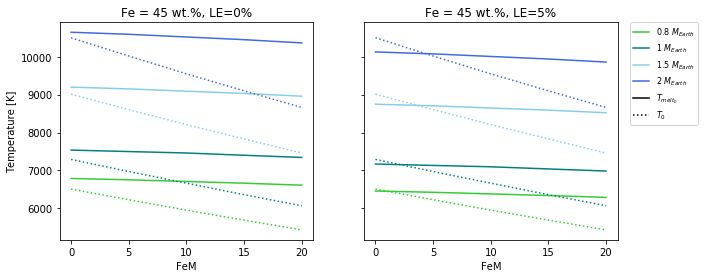

In [13]:
Fe_mantle = [0.,5,10,15,20]
label=["0.8 $M_{Earth}$",'1 $M_{Earth}$','1.5 $M_{Earth}$','2 $M_{Earth}$']
color=["limegreen","teal","skyblue","royalblue"]
fig, ax = plt.subplots(1, 2, figsize=[10,4],sharey=True)
for i in range(len(Masses)):
    ax[0].plot(Fe_mantle,TL0[:,i],color=color[i])
    ax[0].plot(Fe_mantle,T0[:,i],linestyle=':',color=color[i])
    ax[1].plot(Fe_mantle,TL0[:,i+len(Masses)],label=label[i],color=color[i])
    ax[1].plot(Fe_mantle,T0[:,i+len(Masses)],linestyle=':',color=color[i])
ax[0].set_xlabel('FeM')
ax[1].set_xlabel('FeM')
ax[0].set_ylabel('Temperature [K]')
ax[0].set_title('Fe = 45 wt.%, LE=0%')
ax[1].set_title('Fe = 45 wt.%, LE=5%')
handles, labels = ax[1].get_legend_handles_labels()
display = (0,1,2,3,4)
Tmelt0 = plt.Line2D((0,1),(0,0), color='k')
T0 = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle=':')
ax[1].legend([handle for i,handle in enumerate(handles) if i in display]+[Tmelt0,T0],
          [label for i,label in enumerate(labels) if i in display]+['$T_{melt_{0}}$','$T_{0}$'],bbox_to_anchor=(1.05, 1),borderaxespad=0.,fontsize=8)
plt.savefig(plots_folder +"T0_Tmelt.pdf", bbox_inches="tight")
plt.show()

## Run cases for all XFe, all FeM, and a set amount of Mp (LE=0)

In [17]:
Masses_ = [0.8, 1.0, 1.5, 2.]
Fe = [15,20,25,30,35,40,45,50,55,60,65,70,75,80]
Fe_mantle_ = [0.,5.,10.,15.,20.]
S = 0.0

FE, FM = np.meshgrid(Fe,Fe_mantle_)
r_IC_end_M = np.zeros((len(Fe_mantle_),len(Masses_)*len(Fe)))
r_IC_beginning_M = np.zeros_like(r_IC_end_M)
MF_lifetime_M = np.zeros_like(r_IC_end_M)
Q_CMB_end_M = np.zeros_like(r_IC_end_M)
r_OC_M = np.zeros_like(r_IC_end_M)
S_M = np.zeros_like(r_IC_end_M)

for m,mass in enumerate(Masses_):
    for i, iron in enumerate(Fe):
        for j,iron_mantle in enumerate(Fe_mantle_):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            S = S
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)
            
            evo.run()
            #evo.plot(plots_folder)
            
            r_IC_beginning_M[j,i+m*len(Fe)] = evo.planet.r_IC_0/1e3 
            r_IC_end_M[j,i+m*len(Fe)] = evo.r_IC[-1]/1e3      
            r_OC_M[j,i+m*len(Fe)] = evo.planet.r_OC/1e3
            MF_lifetime_M[j,i+m*len(Fe)] = evo.t_mf           
            Q_CMB_end_M[j,i+m*len(Fe)] = evo.Q_CMB[-1] 
            S_M[j,i+m*len(Fe)] = evo.S_t[-1]

0.8 15 0.0 0.0
0.8 15 5.0 0.0
0.8 15 10.0 0.0
0.8 15 15.0 0.0
0.8 15 20.0 0.0
0.8 20 0.0 0.0
0.8 20 5.0 0.0
0.8 20 10.0 0.0
0.8 20 15.0 0.0
0.8 20 20.0 0.0
0.8 25 0.0 0.0
0.8 25 5.0 0.0
0.8 25 10.0 0.0
0.8 25 15.0 0.0
0.8 25 20.0 0.0
0.8 30 0.0 0.0
0.8 30 5.0 0.0
0.8 30 10.0 0.0
0.8 30 15.0 0.0
0.8 30 20.0 0.0
0.8 35 0.0 0.0
0.8 35 5.0 0.0
0.8 35 10.0 0.0
0.8 35 15.0 0.0
0.8 35 20.0 0.0
0.8 40 0.0 0.0
0.8 40 5.0 0.0
0.8 40 10.0 0.0
0.8 40 15.0 0.0
0.8 40 20.0 0.0
0.8 45 0.0 0.0
0.8 45 5.0 0.0
0.8 45 10.0 0.0
0.8 45 15.0 0.0
0.8 45 20.0 0.0
0.8 50 0.0 0.0
0.8 50 5.0 0.0
0.8 50 10.0 0.0
0.8 50 15.0 0.0
0.8 50 20.0 0.0
0.8 55 0.0 0.0
0.8 55 5.0 0.0
0.8 55 10.0 0.0
0.8 55 15.0 0.0
0.8 55 20.0 0.0
0.8 60 0.0 0.0
0.8 60 5.0 0.0
0.8 60 10.0 0.0
0.8 60 15.0 0.0
0.8 60 20.0 0.0
0.8 65 0.0 0.0
0.8 65 5.0 0.0
0.8 65 10.0 0.0
0.8 65 15.0 0.0
0.8 65 20.0 0.0
0.8 70 0.0 0.0
0.8 70 5.0 0.0
0.8 70 10.0 0.0
0.8 70 15.0 0.0
0.8 70 20.0 0.0
0.8 75 0.0 0.0
0.8 75 5.0 0.0
0.8 75 10.0 0.0
0.8 75 15.0 0.0
0.

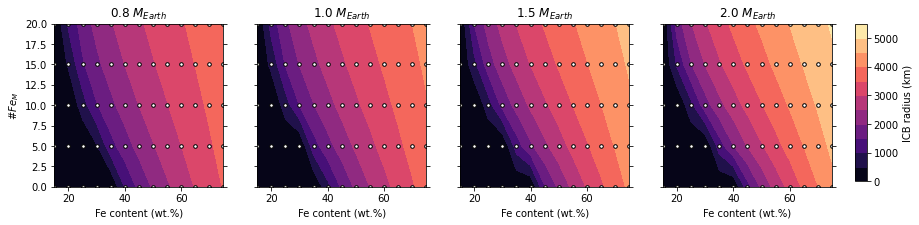

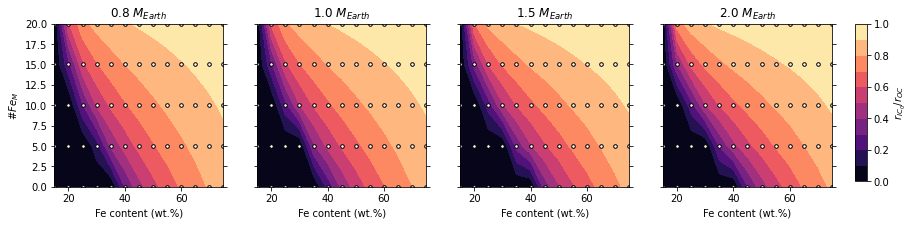

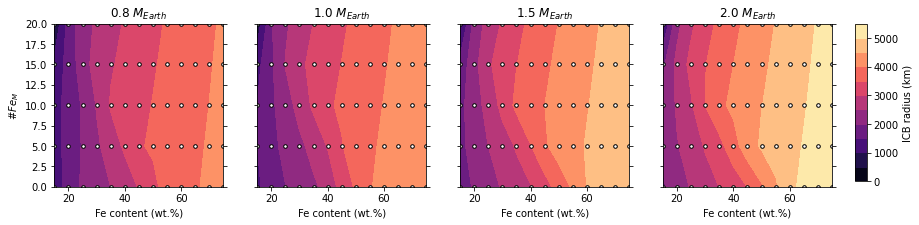

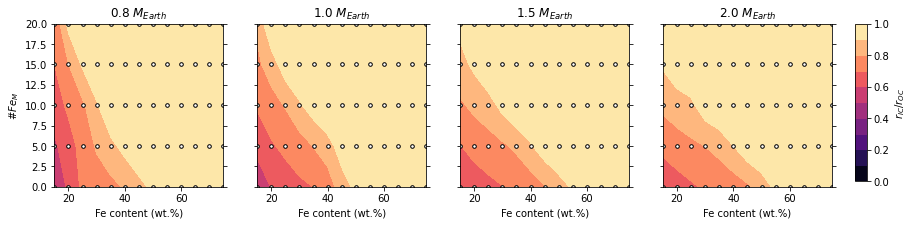

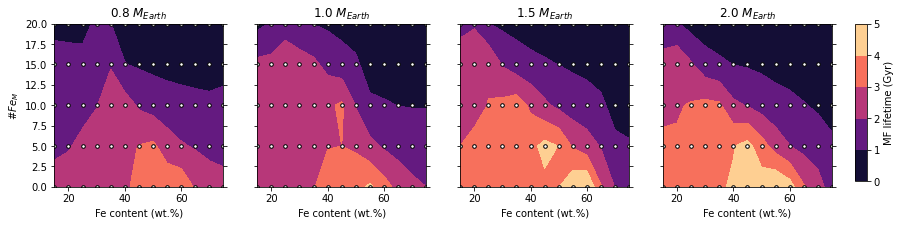

In [19]:
plot_contourfM(FE,FM,r_IC_beginning_M/r_OC_M,Masses_,Fe,Fe_mantle_,levels_ICMF,plots_folder,clabel="$r_{IC_{0}}$/$r_{OC}$",figname="ICMF0_Mp.pdf")

plot_contourfM(FE,FM,r_IC_end_M/r_OC_M,Masses_,Fe,Fe_mantle_,levels_ICMF,plots_folder,clabel="$r_{IC}$/$r_{OC}$",figname="ICMF_Mp.pdf")

plot_contourfM(FE,FM,MF_lifetime_M,Masses_,Fe,Fe_mantle_,levels_MF,plots_folder,Ylabel = "#$Fe_{M}$",clabel="MF lifetime (Gyr)",figname="MF_lifetime_Mp.pdf")

## Run cases for all Mp, all XFe, and a set amount of light elements (FeM=0)

In [6]:
Masses_S = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6,1.7, 1.8,1.9, 2.]
Fe_S = [15,20,25,30,35,40,45,50,55,60,65,70,75,80]
FeM_S = 0.
LE_S = [0.,0.05,0.1]

M_S, F_S = np.meshgrid(Masses_S, Fe_S)
r_IC_end_S = np.zeros((len(Fe_S),len(Masses_S)*len(LE_S)))
r_IC_beginning_S = np.zeros_like(r_IC_end_S)
MF_lifetime_S = np.zeros_like(r_IC_end_S)
MF_strength_S = np.zeros_like(r_IC_end_S)
r_OC_S = np.zeros_like(r_IC_end_S)
S_S = np.zeros_like(r_IC_end_S)
MF_surface= np.zeros_like(r_IC_end_S)
fc = np.zeros_like(r_IC_end_S)

for m,light_elements in enumerate(LE_S):
    for i, mass in enumerate(Masses_S):
        for j,iron in enumerate(Fe_S):
            Mp = mass
            XFe = iron
            S = light_elements
            FeM = FeM_S
            print (Mp,XFe,FeM,S)
            
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)  
            evo = evolution.Evolution(Planet)            
            evo.run()   
            
            r_IC_beginning_S[j,i+m*len(Masses_S)] = evo.planet.r_IC_0/1e3
            r_IC_end_S[j,i+m*len(Masses_S)] = evo.r_IC[-1]/1e3
            r_OC_S[j,i+m*len(Masses_S)] = evo.planet.r_OC/1e3
            MF_lifetime_S[j,i+m*len(Masses_S)] = evo.t_mf           
            S_S[j,i+m*len(Masses_S)] = evo.S_t[-1]
            MF_surface[j,i+m*len(Masses_S)] = np.max(evo.Bs*1e6)
            MF_strength_S[j,i+m*len(Masses_S)] = np.max(evo.M_ratio)
            fc[j,i+m*len(Masses_S)] = ((1.60217662e-19 * MF_surface[j,i+m*len(Masses_S)])/(2*np.pi*9.10938356e-31))*1e-12

0.8 15 0.0 0.0
1740001000.0 0
The magnetic field lifetime is 1.7400010 billion years.
0.8 20 0.0 0.0
1940007000.0 0
The magnetic field lifetime is 1.9400070 billion years.
0.8 25 0.0 0.0
2240001000.0 0
The magnetic field lifetime is 2.2400010 billion years.
0.8 30 0.0 0.0
2270014000.0 0
The magnetic field lifetime is 2.2700140 billion years.
0.8 35 0.0 0.0
2340002000.0 0
The magnetic field lifetime is 2.3400020 billion years.
0.8 40 0.0 0.0
2410005000.0 0
The magnetic field lifetime is 2.4100050 billion years.
0.8 45 0.0 0.0
2480002000.0 0
The magnetic field lifetime is 2.4800020 billion years.
0.8 50 0.0 0.0
2630018000.0 0
The magnetic field lifetime is 2.6300180 billion years.
0.8 55 0.0 0.0
2690013000.0 0
The magnetic field lifetime is 2.6900130 billion years.
0.8 60 0.0 0.0
2820017000.0000005 0
The magnetic field lifetime is 2.8200170 billion years.
0.8 65 0.0 0.0
0.040016750000000004
2620019000.0 40016750.0
The magnetic field lifetime is 2.5800023 billion years.
0.8 70 0.0 0.0
0.0

2950007000.0 0
The magnetic field lifetime is 2.9500070 billion years.
1.4 50 0.0 0.0
3080005000.0 0
The magnetic field lifetime is 3.0800050 billion years.
1.4 55 0.0 0.0
3220000000.0 0
The magnetic field lifetime is 3.2200000 billion years.
1.4 60 0.0 0.0
3520005000.0 0
The magnetic field lifetime is 3.5200050 billion years.
1.4 65 0.0 0.0
2430004000.0 0
The magnetic field lifetime is 2.4300040 billion years.
1.4 70 0.0 0.0
1910000000.0 0
The magnetic field lifetime is 1.9100000 billion years.
1.4 75 0.0 0.0
1590004000.0 0
The magnetic field lifetime is 1.5900040 billion years.
1.4 80 0.0 0.0
1360000000.0 0
The magnetic field lifetime is 1.3600000 billion years.
1.5 15 0.0 0.0
2820010000.0 0
The magnetic field lifetime is 2.8200100 billion years.
1.5 20 0.0 0.0
2800017000.0000005 0
The magnetic field lifetime is 2.8000170 billion years.
1.5 25 0.0 0.0
2840008000.0 0
The magnetic field lifetime is 2.8400080 billion years.
1.5 30 0.0 0.0
2890002999.9999995 0
The magnetic field lifetime

2230015000.0 0
The magnetic field lifetime is 2.2300150 billion years.
0.8 35 0.0 0.05
2280022999.9999995 0
The magnetic field lifetime is 2.2800230 billion years.
0.8 40 0.0 0.05
2330004000.0 0
The magnetic field lifetime is 2.3300040 billion years.
0.8 45 0.0 0.05
2280004000.0 0
The magnetic field lifetime is 2.2800040 billion years.
0.8 50 0.0 0.05
2310004000.0 0
The magnetic field lifetime is 2.3100040 billion years.
0.8 55 0.0 0.05
2370005000.0 0
The magnetic field lifetime is 2.3700050 billion years.
0.8 60 0.0 0.05
2460005000.0 0
The magnetic field lifetime is 2.4600050 billion years.
0.8 65 0.0 0.05
0.040016750000000004
2520006000.0 40016750.0
The magnetic field lifetime is 2.4799893 billion years.
0.8 70 0.0 0.05
0.04001106
2700014000.0 40011060.0
The magnetic field lifetime is 2.6600029 billion years.
0.8 75 0.0 0.05
0.04000018
3800008000.0 40000180.0
The magnetic field lifetime is 3.7600078 billion years.
0.8 80 0.0 0.05
0.04000651
1580001000.0 40006510.0
The magnetic field 

3050011000.0 0
The magnetic field lifetime is 3.0500110 billion years.
1.4 65 0.0 0.05
3990008000.0 0
The magnetic field lifetime is 3.9900080 billion years.
1.4 70 0.0 0.05
4490004000.0 0
The magnetic field lifetime is 4.4900040 billion years.
1.4 75 0.0 0.05
3000002000.0 0
The magnetic field lifetime is 3.0000020 billion years.
1.4 80 0.0 0.05
2200002999.9999995 0
The magnetic field lifetime is 2.2000030 billion years.
1.5 15 0.0 0.05
2810015999.9999995 0
The magnetic field lifetime is 2.8100160 billion years.
1.5 20 0.0 0.05
2790022000.0 0
The magnetic field lifetime is 2.7900220 billion years.
1.5 25 0.0 0.05
2840008000.0 0
The magnetic field lifetime is 2.8400080 billion years.
1.5 30 0.0 0.05
2860015999.9999995 0
The magnetic field lifetime is 2.8600160 billion years.
1.5 35 0.0 0.05
2970014000.0 0
The magnetic field lifetime is 2.9700140 billion years.
1.5 40 0.0 0.05
3030007000.0 0
The magnetic field lifetime is 3.0300070 billion years.
1.5 45 0.0 0.05
2840000999.9999995 0
The 

2220007000.0 0
The magnetic field lifetime is 2.2200070 billion years.
0.8 40 0.0 0.1
2270005000.0 0
The magnetic field lifetime is 2.2700050 billion years.
0.8 45 0.0 0.1
2240002999.9999995 0
The magnetic field lifetime is 2.2400030 billion years.
0.8 50 0.0 0.1
2240002999.9999995 0
The magnetic field lifetime is 2.2400030 billion years.
0.8 55 0.0 0.1
2130013000.0 0
The magnetic field lifetime is 2.1300130 billion years.
0.8 60 0.0 0.1
2110009000.0 0
The magnetic field lifetime is 2.1100090 billion years.
0.8 65 0.0 0.1
0.040016750000000004
2050007000.0 40016750.0
The magnetic field lifetime is 2.0099902 billion years.
0.8 70 0.0 0.1
0.04001106
2010004000.0 40011060.0
The magnetic field lifetime is 1.9699929 billion years.
0.8 75 0.0 0.1
0.04000018
1940002000.0000002 40000180.0
The magnetic field lifetime is 1.9000018 billion years.
0.8 80 0.0 0.1
0.04000651
1160012000.0 40006510.0
The magnetic field lifetime is 1.1200055 billion years.
0.9 15 0.0 0.1
2290020000.0 0
The magnetic fiel

3300006000.0 0
The magnetic field lifetime is 3.3000060 billion years.
1.4 70 0.0 0.1
3550010000.0 0
The magnetic field lifetime is 3.5500100 billion years.
1.4 75 0.0 0.1
4440010999.999999 0
The magnetic field lifetime is 4.4400110 billion years.
1.4 80 0.0 0.1
0.04000814000000001
4390012000.0 40008140.00000001
The magnetic field lifetime is 4.3500039 billion years.
1.5 15 0.0 0.1
2810015999.9999995 0
The magnetic field lifetime is 2.8100160 billion years.
1.5 20 0.0 0.1
2790022000.0 0
The magnetic field lifetime is 2.7900220 billion years.
1.5 25 0.0 0.1
2830028000.0 0
The magnetic field lifetime is 2.8300280 billion years.
1.5 30 0.0 0.1
2850020999.9999995 0
The magnetic field lifetime is 2.8500210 billion years.
1.5 35 0.0 0.1
2960002000.0 0
The magnetic field lifetime is 2.9600020 billion years.
1.5 40 0.0 0.1
3020019000.0 0
The magnetic field lifetime is 3.0200190 billion years.
1.5 45 0.0 0.1
2830000999.9999995 0
The magnetic field lifetime is 2.8300010 billion years.
1.5 50 0.0

In [10]:
levels_rIC = np.linspace(0, 5500, 12)
levels_ICMF = np.linspace(0, 1, 11)
levels_MF = np.linspace(0, 5, 11)
levels_rIC08 = np.linspace(0,5,6)
levels_MFstr = np.linspace(0,15,16)
size = 13

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)

def plot_contourf(X,Y,arr,Masses,Fe,Fe_mantle,levels,plots_folder,colormap=plt.cm.magma,clabel="ICB radius (km)",figname="r_IC_FeM.pdf"):
    fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
    plt.subplots_adjust(wspace = 0.2)
    
    for i in range(len(Fe_mantle)):
        sc = ax[i].contourf(X,Y,arr[:,i*len(Masses):len(Masses)*(i+1)],levels, cmap = colormap)
        sc2 = ax[i].contour(X,Y,arr[:,i*len(Masses):len(Masses)*(i+1)],levels,colors=('white',),linestyles=('-',),linewidths=(1,))
        ax[i].clabel(sc2, fmt = '%2.1f', colors = 'white', fontsize=11)
        #for a in range(len(Masses)):
        #    for b in range(len(Fe)):
        #        ax[i].scatter(Masses[a],Fe[b],s=size,color='white',edgecolors='k')
        if i!=0:
            ax[i].set_ylabel("")
        else:
            ax[i].set_ylabel("Fe content (wt.%)")
        ax[i].set_title('Bulk LE content:{}%'.format(Fe_mantle[i]*1e2))
        ax[i].yaxis.set_ticks_position('both')
        ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
        ax[i].set_xlim([0.8,2.0])
        ax[i].set_ylim([15,80])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
    cb = fig.colorbar(sc, cax=cbar_ax)
    cb.set_label(clabel)
    plt.savefig(plots_folder + figname, bbox_inches="tight")
    plt.show()

In [11]:
print (np.max(MF_lifetime_S))

5.0


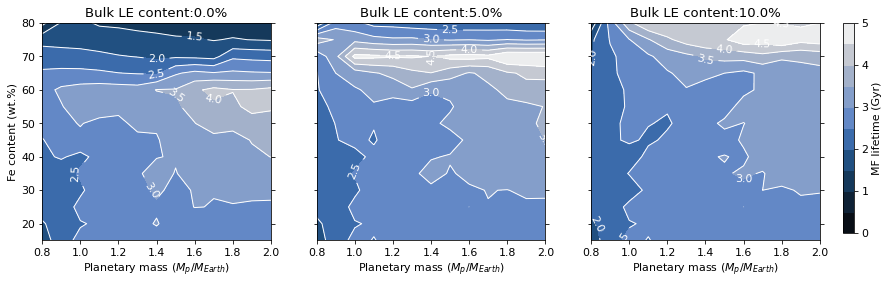

In [12]:
levels_S = np.linspace(0,90,10)
levels_MFsurf = np.linspace(0,700,8)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 11}

plt.rc('font', **font)       

# plot_contourf(M_S,F_S,r_IC_beginning_S,Masses_S,Fe_S,LE_S,levels_rIC,plots_folder,clabel="ICB radius (km)",figname="r_IC0_S.pdf")
#plot_contourf(M_S,F_S,r_IC_beginning_S/r_OC_S,Masses_S,Fe_S,LE_S,levels_ICMF,plots_folder,clabel="$r_{IC_{0}}$/$r_{OC}$",figname="ICMF0_S.pdf")

#plot_contourf(M_S,F_S,r_IC_end_S/r_OC_S,Masses_S,Fe_S,LE_S,levels_ICMF,plots_folder,clabel="$r_{IC}$/$r_{OC}$",figname="ICMF_S.pdf")

plot_contourf(M_S,F_S,MF_lifetime_S,Masses_S,Fe_S,LE_S,levels_MF,plots_folder,colormap=oslo,clabel="MF lifetime (Gyr)",figname="MF_lifetime_S.pdf")
#plot_contourf(M_S,F_S,S_S*1e2,Masses_S,Fe_S,LE_S,levels_S,plots_folder,colormap=bamako,clabel="Light elements in the OC (%)",figname="S_S.pdf")
#plot_contourf(M_S,F_S,MF_surface,Masses_S,Fe_S,LE_S,levels_MFsurf,plots_folder,colormap=oslo,clabel="Surface MF intensity ($\mu T$)",figname="M_surfS.pdf")

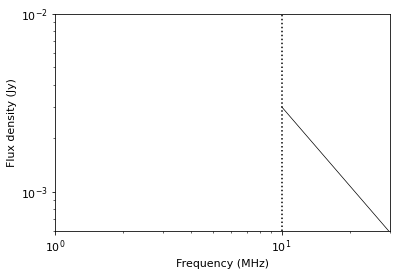

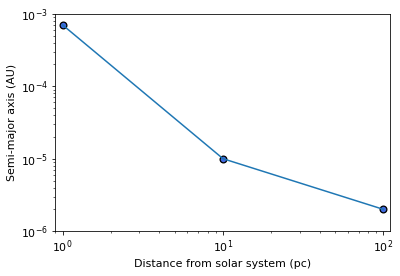

In [123]:
#print (np.max(MF_surface))

MJ = 18000.
aJ = 5.2044
Prad = np.zeros_like(r_IC_end_S)
phi = np.zeros_like(r_IC_end_S)
s = 1.33
a = 0.02

for m,light_elements in enumerate(LE_S):
    for i, mass in enumerate(Masses_S):
        for j,iron in enumerate(Fe_S):
            if fc[j,i+m*len(Masses_S)]>10. and MF_surface[j,i+m*len(Masses_S)]>384.:
                Prad[j,i+m*len(Masses_S)] = (MF_strength_S[j,i+m*len(Masses_S)]/MJ)**(0.58) * (aJ/a)**(1.17)*4*1e9 # W
                phi[j,i+m*len(Masses_S)] = (Prad[j,i+m*len(Masses_S)] / (4*np.pi * ((s *3.086e16)**2.)*0.5*fc[j,i+m*len(Masses_S)]*1e6)) *1e26# Jansky
            else:
                phi[j,i+m*len(Masses_S)] = 0.
            
plt.scatter(fc,phi,s=45,edgecolor='k',linewidth=1.3,color='royalblue')
plt.axvline(10,1e-7,300,color='black',linestyle=':')
x = [10,100]
y = [3e-3,1e-4]
plt.loglog()
plt.plot(x,y,color='black',linewidth=0.7)
plt.xlim([1,30])
plt.ylim([6e-4,1e-2])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux density (Jy)')
plt.savefig(plots_folder+'Flux_density.pdf')
plt.show()

x = [1,10,100]
y = [7e-4,1e-5,2e-6]
plt.loglog()
plt.scatter(x,y,s=45,edgecolor='k',linewidth=1.3,color='royalblue')
plt.plot(x,y)
plt.xlim([0.9,110])
plt.ylim([1e-6,1e-3])
plt.xlabel('Distance from solar system (pc)')
plt.ylabel('Semi-major axis (AU)')
plt.savefig(plots_folder+'sem_ax.pdf')
plt.show()

## Run cases for all XFe, all LE, and a set amount of masses (FeM=0)

In [10]:
Masses_SM = [0.8, 1.0, 1.5, 2.]
Fe_SM = [15,20,25,30,35,40,45,50,55,60,65,70,75,80]
Fe_mantle_SM = 0.
LE_SM = [0.0,0.02,0.04,0.06,0.08,0.1]

F_SM, M_SM = np.meshgrid(Fe_SM,LE_SM)
r_IC_end_SM = np.zeros((len(LE_SM),len(Masses_SM)*len(Fe_SM)))
r_IC_beginning_SM = np.zeros_like(r_IC_end_SM)
MF_lifetime_SM = np.zeros_like(r_IC_end_SM)
Q_CMB_end_SM = np.zeros_like(r_IC_end_SM)
r_OC_SM = np.zeros_like(r_IC_end_SM)

for m,mass in enumerate(Masses_SM):
    for i, iron in enumerate(Fe_SM):
        for j,light_elements in enumerate(LE_SM):
            Mp = mass
            XFe = iron
            FeM = Fe_mantle_SM
            S = light_elements
            print (Mp,XFe,FeM,S)
            Planet = evolution.Rocky_Planet(Mp,XFe,FeM,S)
            evo = evolution.Evolution(Planet)
            
            evo.run()
            #evo.plot(plots_folder)
            
            r_IC_beginning_SM[j,i+m*len(Fe_SM)] = evo.planet.r_IC_0/1e3 
            r_IC_end_SM[j,i+m*len(Fe_SM)] = evo.r_IC[-1]/1e3
            r_OC_SM[j,i+m*len(Fe_SM)] = evo.planet.r_OC/1e3
            if np.isnan(r_IC_end_SM[j,i+m*len(Fe_SM)]):# == None:
                r_IC_end_SM[j,i+m*len(Fe_SM)] = r_OC_SM[j,i+m*len(Fe_SM)]
            MF_lifetime_SM[j,i+m*len(Fe_SM)] = evo.t_mf           
            Q_CMB_end_SM[j,i+m*len(Fe_SM)] = evo.Q_CMB[-1]

0.8 15 0.0 0.0
The magnetic field lifetime is 1.95 billion years.
0.8 15 0.0 0.02
The magnetic field lifetime is 1.95 billion years.
0.8 15 0.0 0.04
The magnetic field lifetime is 1.95 billion years.
0.8 15 0.0 0.06
The magnetic field lifetime is 1.95 billion years.
0.8 15 0.0 0.08
The magnetic field lifetime is 1.95 billion years.
0.8 15 0.0 0.1
The magnetic field lifetime is 1.95 billion years.
0.8 20 0.0 0.0
The magnetic field lifetime is 1.96 billion years.
0.8 20 0.0 0.02
The magnetic field lifetime is 1.96 billion years.
0.8 20 0.0 0.04
The magnetic field lifetime is 1.96 billion years.
0.8 20 0.0 0.06
The magnetic field lifetime is 1.96 billion years.
0.8 20 0.0 0.08
The magnetic field lifetime is 1.96 billion years.
0.8 20 0.0 0.1
The magnetic field lifetime is 1.96 billion years.
0.8 25 0.0 0.0
The magnetic field lifetime is 2.28 billion years.
0.8 25 0.0 0.02
The magnetic field lifetime is 2.28 billion years.
0.8 25 0.0 0.04
The magnetic field lifetime is 2.25 billion years.


The magnetic field lifetime is 2.41 billion years.
1.0 45 0.0 0.0
The magnetic field lifetime is 2.76 billion years.
1.0 45 0.0 0.02
The magnetic field lifetime is 2.67 billion years.
1.0 45 0.0 0.04
The magnetic field lifetime is 2.63 billion years.
1.0 45 0.0 0.06
The magnetic field lifetime is 2.62 billion years.
1.0 45 0.0 0.08
The magnetic field lifetime is 2.59 billion years.
1.0 45 0.0 0.1
The magnetic field lifetime is 2.56 billion years.
1.0 50 0.0 0.0
The magnetic field lifetime is 2.92 billion years.
1.0 50 0.0 0.02
The magnetic field lifetime is 2.82 billion years.
1.0 50 0.0 0.04
The magnetic field lifetime is 2.70 billion years.
1.0 50 0.0 0.06
The magnetic field lifetime is 2.63 billion years.
1.0 50 0.0 0.08
The magnetic field lifetime is 2.60 billion years.
1.0 50 0.0 0.1
The magnetic field lifetime is 2.57 billion years.
1.0 55 0.0 0.0
The magnetic field lifetime is 3.02 billion years.
1.0 55 0.0 0.02
The magnetic field lifetime is 2.90 billion years.
1.0 55 0.0 0.04


The magnetic field lifetime is 2.51 billion years.
1.5 75 0.0 0.02
The magnetic field lifetime is 3.56 billion years.
1.5 75 0.0 0.04
The magnetic field lifetime is 5.00 billion years.
1.5 75 0.0 0.06
The magnetic field lifetime is 4.33 billion years.
1.5 75 0.0 0.08
The magnetic field lifetime is 3.91 billion years.
1.5 75 0.0 0.1
The magnetic field lifetime is 3.62 billion years.
1.5 80 0.0 0.0
The magnetic field lifetime is 2.32 billion years.
1.5 80 0.0 0.02
The magnetic field lifetime is 3.08 billion years.
1.5 80 0.0 0.04
The magnetic field lifetime is 4.13 billion years.
1.5 80 0.0 0.06
The magnetic field lifetime is 5.00 billion years.
1.5 80 0.0 0.08
The magnetic field lifetime is 4.58 billion years.
1.5 80 0.0 0.1
The magnetic field lifetime is 4.04 billion years.
2.0 15 0.0 0.0
The magnetic field lifetime is 2.96 billion years.
2.0 15 0.0 0.02
The magnetic field lifetime is 2.94 billion years.
2.0 15 0.0 0.04
The magnetic field lifetime is 2.93 billion years.
2.0 15 0.0 0.06

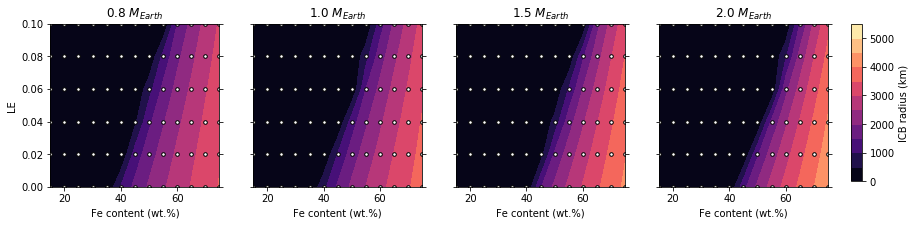

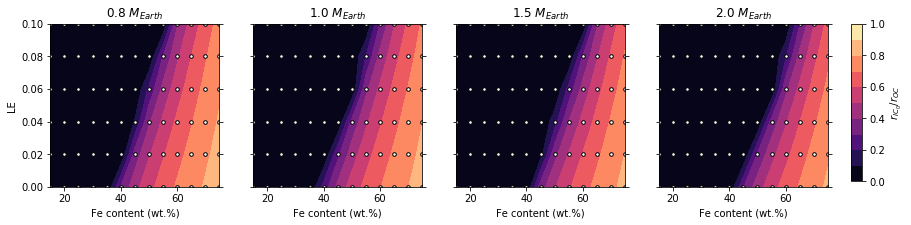

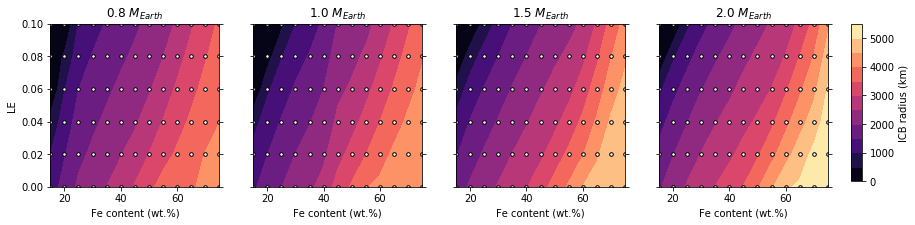

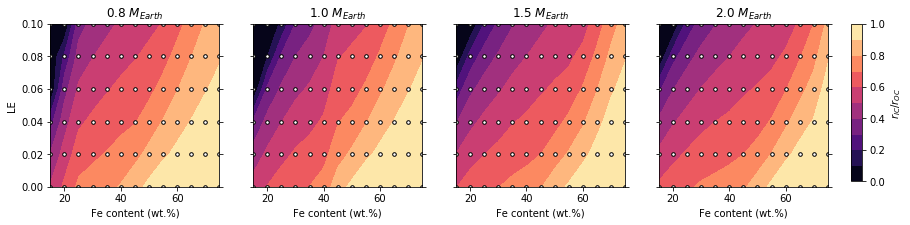

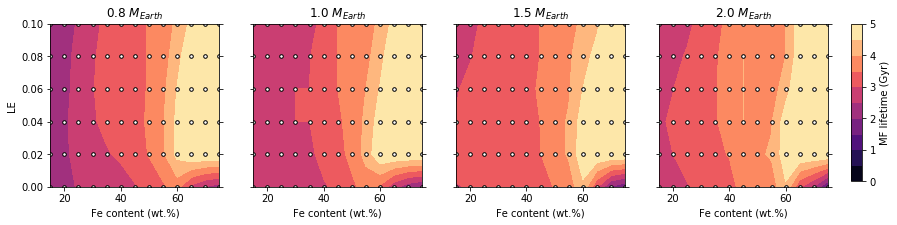

In [48]:
#plot_contourfM(F_SM,M_SM,r_IC_beginning_SM,Masses_SM,Fe_SM,LE_SM,levels_rIC,plots_folder,Ylabel = "LE",clabel="ICB radius (km)",figname="r_IC0_MpS.pdf")
plot_contourfM(F_SM,M_SM,r_IC_beginning_SM/r_OC_SM,Masses_SM,Fe_SM,LE_SM,levels_ICMF,plots_folder,Ylabel = "LE",clabel="$r_{IC_{0}}$/$r_{OC}$",figname="ICMF0_MpS.pdf")

#plot_contourfM(F_SM,M_SM,r_IC_end_SM,Masses_SM,Fe_SM,LE_SM,levels_rIC,plots_folder,Ylabel = "LE",clabel="ICB radius (km)",figname="r_IC_MpSTEST.pdf")
plot_contourfM(F_SM,M_SM,r_IC_end_SM/r_OC_SM,Masses_SM,Fe_SM,LE_SM,levels_ICMF,plots_folder,Ylabel = "LE",clabel="$r_{IC}$/$r_{OC}$",figname="ICMF_MpS.pdf")

levels_MF = np.linspace(0, 5, 11)
plot_contourfM(F_SM,M_SM,MF_lifetime_SM,Masses_SM,Fe_SM,LE_SM,levels_MF,plots_folder,Ylabel = "LE",clabel="MF lifetime (Gyr)",figname="MF_lifetime_MpS.pdf")

## Variation of QCMB

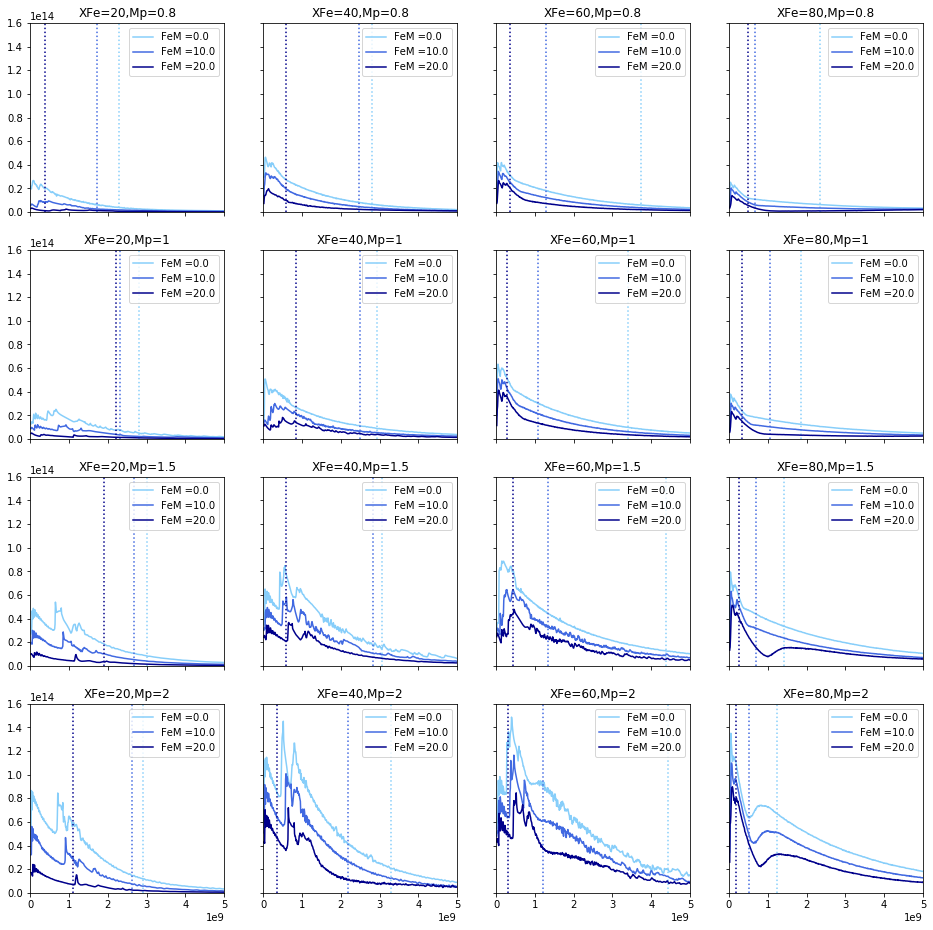

In [20]:
Mp = [0.8,1,1.5,2]
XFe = [20,40,60,80]
FeM = [0.,10.,20.]

qcmb = np.zeros((499,len(FeM)),dtype=np.float64)
r_OC = np.zeros((len(FeM),1),dtype=np.float64)
MF = np.zeros_like(r_OC)
colors = ["lightskyblue","royalblue","darkblue"]
fig, ax = plt.subplots(len(Mp), len(XFe), figsize=[16,16],sharey=True,sharex=True)
for i in range(len(Mp)):
    for j in range(len(XFe)):
        for k in range(len(FeM)):
            qcmb_ev = pd.read_csv("./Q_CMB/res_t_HS_Tm_Tb_qs_qc_M{:02d}_Fe{:02d}_#FeM{:02d}.res".format(int(10*Mp[i]),int(XFe[j]),int(FeM[k])), skipinitialspace=True, sep=" ", index_col=False,skiprows=[0])
            qcmb_ev.columns = ["time", "H_rad", "T_um","T_cmb","q_surf","qcmb"]
            time_vector = qcmb_ev["time"] *1e6
            qcmb[:,k] = qcmb_ev["qcmb"]
            
            Planet = evolution.Rocky_Planet(Mp[i],XFe[j],FeM[k],0.)
            evo = evolution.Evolution(Planet)
            evo.run()
            r_OC[k] = evo.planet.r_OC
            MF[k] = evo.t_mf
            
            labels = "FeM ={}".format(FeM[k])
            ax[i,j].axvline(MF[k]*1e9, ymin=0, ymax=1.6e14,color=colors[k],linestyle=':')
            ax[i,j].plot(time_vector,qcmb[:,k]*r_OC[k]**2 * 4 * np.pi,color=colors[k],label=labels)
            ax[i,j].set_title('XFe={},Mp={}'.format(XFe[j],Mp[i]))
            ax[i,j].legend(loc='upper right')
            ax[i,j].set_ylim(bottom=0,top=1.6e14)
plt.xlim([0,5e9])
plt.show()

- The higher the planetary mass, the higher the obtained Q_CMB.
- The lower FeM (i.e, the smaller the initial/final inner core), the higher Q_CMB. Why is that?
- The higher XFe (i.e., the larger the initial/final inner core), the higher Q_CMB (unless XFe becomes very high).
- CMB curves for high XFe look "smoother", with less perturbations, BUT with a later overturn arising from instabilities, such as an unstable density stratifications.
- Initial large overturn occurs later for high FeM (large initial inner core) and low XFe (small initial inner core).
- There is not a huge dependency on the planetary mass, although the timing of the overturn is delayed for large masses.
- In terms of the relation between magnetic field lifetime and the overturn timing, we see that the earlier the overturn takes place (and thus, the lower FeM) during the planet's evolution, the longer the magnetic field lifetime ends up being. This is also seen for changing XFe, but...
- There is a "sweet spot" in terms of planetary XFe. If it gets too high (i.e., XFe=80) the magnetic field shuts off earlier, because the initial inner core is already too large. 
- When FeM higher, MF strength is lower.

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

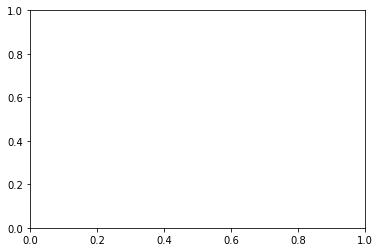

In [15]:
X = np.linspace(0,1,100)

def TX(X):
    return (1./(1.-np.log(1.-S)))


T_X = TX(X)

plt.plot(X*100,T_X)
plt.xlabel("Fraction of light elements (%)")
plt.xlim([0,100])
plt.show()

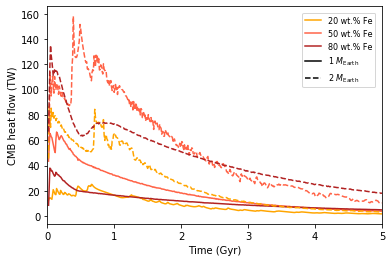

In [40]:
Mp = [1,2]
XFe = [20,50,80]
FeM = 0.

qcmb = np.zeros((499,len(XFe)*len(Mp)),dtype=np.float64)
r_OC = np.zeros((1,1),dtype=np.float64)
MF = np.zeros_like(r_OC)
colors = ["lightskyblue","royalblue","darkblue"]
for i in range(len(Mp)):
    for j in range(len(XFe)):
        qcmb_ev = pd.read_csv("./Q_CMB/res_t_HS_Tm_Tb_qs_qc_M{:02d}_Fe{:02d}_#FeM{:02d}.res".format(int(10*Mp[i]),int(XFe[j]),int(FeM)), skipinitialspace=True, sep=" ", index_col=False,skiprows=[0])
        qcmb_ev.columns = ["time", "H_rad", "T_um","T_cmb","q_surf","qcmb"]
        time_vector = qcmb_ev["time"] *1e6
        qcmb[:,i+j*len(Mp)] = qcmb_ev["qcmb"]
        labels= ['20 wt.% Fe','50 wt.% Fe','80 wt.% Fe']
        Planet = evolution.Rocky_Planet(Mp[i],XFe[j],FeM,0.)
        evo = evolution.Evolution(Planet)
        evo.run()
        r_OC = evo.planet.r_OC
        
        colors = ['orange','tomato','firebrick']
        ls =['-','--']
        ax = plt.gca()
        if i==0:
            ax.plot(time_vector/1e9,(qcmb[:,i+j*len(Mp)]*r_OC**2 * 4 * np.pi)/1e12,color=colors[j],linestyle=ls[i],label=labels[j])
        else:
            ax.plot(time_vector/1e9,(qcmb[:,i+j*len(Mp)]*r_OC**2 * 4 * np.pi)/1e12,color=colors[j],linestyle=ls[i])
        ax.set_xlabel('Time (Gyr)')
        ax.set_ylabel('CMB heat flow (TW)')
        ax.set_xlim(left=0,right=5)
        handles, labels = ax.get_legend_handles_labels()
        display = (0,1,2,3,4)
        M1 = plt.Line2D((0,1),(0,0), color='k')
        M2 = plt.Line2D((0,1),(0,0), color='k',marker='',linestyle='--')
        ax.legend([handle for i,handle in enumerate(handles) if i in display]+[M1,M2],
          [label for i,label in enumerate(labels) if i in display]+['1 $M_{\mathrm{Earth}}$','2 $M_{\mathrm{Earth}}$'],bbox_to_anchor=(0.98, 0.97),borderaxespad=0.,fontsize=8)
plt.savefig('Q_CMB.pdf')
plt.show()